In [14]:
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.local import LocalQuantumJob
from braket.jobs.image_uris import Framework, retrieve_image
import time

aws_session = AwsSession(default_bucket="amazon-braket-us-west-1-lukasvoss")

In [15]:
num_total_updates = 160

hyperparams = {
    "num_total_updates": num_total_updates, 
}

#Name your job so that it can be later identified
job_name = f'cx-gate-calibration-{num_total_updates}-updates-{str(int(time.time()))}'

# Specify one of the ready-to-use containers provided by Amazon Braket
image_uri = retrieve_image(Framework.PL_PYTORCH, AwsSession().region)

q_env_config_path = 'config_yamls/q_env_gate_config.yaml'
agent_config_path = 'config_yamls/agent_config.yaml'

input_config = {
    'q-env-config': q_env_config_path,
    'agent-config': agent_config_path,
}

In [16]:
job = AwsQuantumJob.create(
    #Run this hybrid job on the SV1 simulator
    device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    #The directory or single file containing the code to run.
    source_module="needed_files",
    #The main script or function the job will run.
    entry_point="needed_files.algorithm_script:calibrate_gate",
    #Set the name of the job
    job_name=job_name,
    # Set the hyperparameters
    hyperparameters=hyperparams,
    # Specify the image to use for the container to run the script in
    # image_uri=image_uri,
    # Define the file that contains the input data but not relevant for the minimal example
    input_data=input_config,
    wait_until_complete=True,
    aws_session=aws_session,
)

Initializing Braket Job: arn:aws:braket:us-west-1:229406906664:job/cx-gate-calibration-160-updates-1706592865
.......................
2024-01-30 05:36:42,779 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-30 05:36:42,780 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-30 05:36:42,793 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-30 05:36:42,794 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-30 05:36:42,805 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-01-30 05:36:42,806 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-30 05:36:42,816 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "agent-config": "/opt/ml/input

In [17]:
while job.state() not in job.TERMINAL_STATES:
    print(job.state())
    time.sleep(30)

print(job.state())
print(job.result())

COMPLETED
{'avg_reward': [0.22837843312365672, 0.3132147396517663, 0.2312005639466409, 0.31051705993953255, 0.24327014035824396, 0.2781520408971321, 0.26819807241375915, 0.3272508339116173, 0.43534509676073013, 0.42285634272474754, 0.21745461836790614, 0.2440593973680104, 0.4914601855405514, 0.4822483183904452, 0.49045168862603905, 0.35906525208732937, 0.2171011591932606, 0.4482059287981141, 0.23361012905297063, 0.4527324368463706, 0.30596801982494537, 0.2481912128526646, 0.2574302840314307, 0.2768292655883652, 0.25886782764844635, 0.25889830906912176, 0.44826618161814796, 0.5085248881104891, 0.24137253039727907, 0.3080735610390111, 0.52072705568623, 0.29092473386971046, 0.5075745949494437, 0.5434367065529708, 0.5271243965481364, 0.3828516640991711, 0.5298862038224089, 0.39172336255623263, 0.5496614058073386, 0.42956894422231207, 0.5801655341051695, 0.5887190312267032, 0.60083082276244, 0.6039583812653356, 0.6818816609993223, 0.5055246690582582, 0.7326883991845489, 0.913054609546607, 0

In [18]:
job.result().keys()

dict_keys(['avg_reward', 'std_actions', 'fidelities', 'avg_action_history', 'action_vector', 'task_summary', 'estimated cost'])

In [19]:
avg_reward = job.result()['avg_reward']
std_actions = job.result()['std_actions']
fidelities = job.result()['fidelities']

#### Visualize results

In [20]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

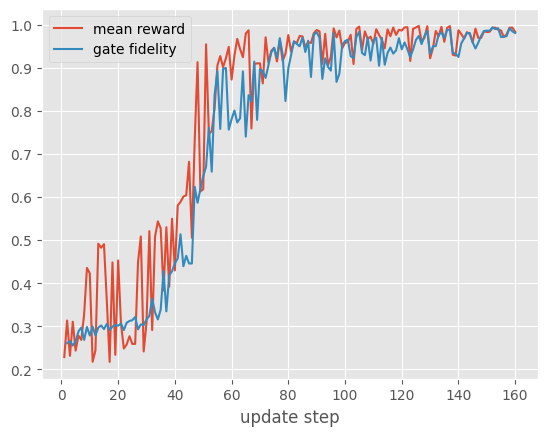

In [21]:
plt.plot(np.arange(1, num_total_updates+1), avg_reward, label='mean reward')
plt.plot(np.arange(2, num_total_updates+1), fidelities, label='gate fidelity')
plt.xlabel('update step')
plt.legend()

In [26]:
fidelities[-1]

0.9806323739030413

In [22]:
std_actions_componentwise = list(zip(*std_actions))

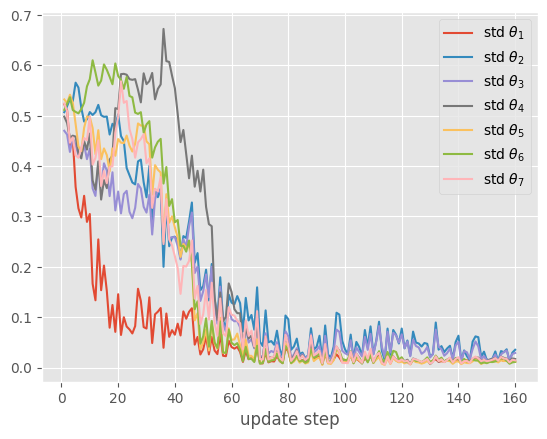

In [23]:
for ind, param in enumerate(std_actions_componentwise):
    plt.plot(np.arange(1, num_total_updates+1), param, label=r'std $\theta_{}$'.format(ind+1))

plt.xlabel('update step')
plt.legend()

#### Best Action Vector

In [24]:
best_action_vector = job.result()['action_vector']

In [25]:
best_action_vector

[0.05572796240448952,
 -0.23899486660957336,
 -1.2708104848861694,
 -1.5826953649520874,
 -1.7812086343765259,
 1.6437638998031616,
 1.557625651359558]